# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
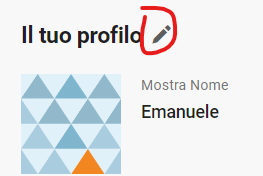 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

In [1]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 

In [2]:
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


Pandas va installato anche se si installa prima Dask

In [3]:
from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import dask.dataframe as dd

In [4]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors

In [5]:
def connect_ARPA_api(token):
    """
    Function to connect to ARPA API.

        Parameters:
            - token (str): the ARPA token obtained from Open Data Lombardia website

        Returns:
            - client: client session
            
    """
    client = Socrata("www.dati.lombardia.it", app_token=token)

    return client


client = connect_ARPA_api(arpa_token)
stations_info = client.get_all(stationsId)

In [6]:
stations_df = pd.DataFrame(stations_info)
stations_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13T00:00:00.000,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaN
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28T00:00:00.000,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaN
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN


Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

In [7]:
temperature_sensors = (stations_df.loc[(stations_df['tipologia'] == 'Temperatura') & (stations_df['storico'] == 'N')]).idsensore.tolist()

In [8]:
temperature_sensors = list(map(int, temperature_sensors))
len(temperature_sensors)

197

**Request data time series**

In [9]:
def req_ARPA_start_end_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

      Parameters:
        - client: the client session

      Returns: 
        - start_API_date (str): starting date for available data inside the API.
        - end_API_date (str): ending date for available data inside the API.
        
    """
    weather_sensor_id = "647i-nhxk" #Weather sensors id
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    min_max_dates = client.get(weather_sensor_id, query=query)[0] #Get max and min dates from the list
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")+timedelta(days=1)
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_API_date = start_API_date.strftime("%Y-%m-%d")
    end_API_date = end_API_date.strftime("%Y-%m-%d")

    return start_API_date, end_API_date

In [10]:
start_date, end_date = req_ARPA_start_end_API(client)
print("The data from the API are available from: " + start_date + " up to: " + end_date)

The data from the API are available from: 2023-01-13 up to: 2023-01-20


In [11]:
def req_ARPA_data_API(client, start_date, end_date):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

      Parameters:
        - client: the client session
        - start date (str): the start date in yyy-mm-dd format
        - end date (str): the end date in yyy-mm-dd format

      Returns: 
        - time_series: time series of values requested with the query for all sensors
        
    """
    weather_sensor_id = "647i-nhxk"
    query = """
      select
          *
      where data between \'{}\' and \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    time_series = client.get(weather_sensor_id, query=query)

    return time_series

In [12]:
sensors_values_API = req_ARPA_data_API(client, start_date, end_date)

In [13]:
print("Total lenght of the list containing the values from ARPA sensors:", len(sensors_values_API))

Total lenght of the list containing the values from ARPA sensors: 499815


In [14]:
sensors_values_df_API = pd.DataFrame(sensors_values_API, columns=['idsensore','data','valore'])

In [15]:
sensors_values_df_API

,idsensore,data,valore
0,2116,2023-01-16T06:30:00.000,0
1,14207,2023-01-16T05:50:00.000,0
2,9074,2023-01-16T09:10:00.000,1.4
3,8122,2023-01-16T05:20:00.000,0
4,11190,2023-01-16T06:10:00.000,43
...,...,...,...
499810,17593,2023-01-19T05:10:00.000,0
499811,19116,2023-01-19T01:30:00.000,0.5
499812,9399,2023-01-19T02:10:00.000,44
499813,32410,2023-01-19T03:30:00.000,3.8


In [16]:
sensors_values_df_API['data'] = pd.to_datetime(sensors_values_df_API['data'])
sensors_values_df_API = sensors_values_df_API.sort_values(by='data', ascending=False).reset_index(drop=True)
print(sensors_values_df_API.head())

  idsensore                data valore
0      5865 2023-01-19 05:50:00    2.2
1     19062 2023-01-19 05:50:00    0.9
2      6432 2023-01-19 05:50:00    0.4
3      5910 2023-01-19 05:50:00      2
4     19107 2023-01-19 05:50:00    2.6


# Values from csv files

In [17]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

            Parameters:
                year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

            Returns:
                None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
    req = requests.get(url)
    
    # Writing the file to the local file system
    with open(filename,'wb') as output_file:
        output_file.write(req.content)
    print(('Downloading {filename} -> Completed').format(filename = filename))
    
    #Loading the .zip and creating a zip object
    with ZipFile(filename, 'r') as zObject:
        # Extracting all the members of the zip into a specific location
        zObject.extractall()
    
    csv_file=str(year)+'.csv'
    print(("File unzipped: {filename}").format(filename=filename))
    print(("File csv saved: {filename}").format(filename=csv_file))
    
    #Remove the zip folder
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print("The file does not exist")

In [18]:
year = 2022
csv_file = str(year)+'.csv'

In [19]:
download_extract_csv_from_year(str(year))

File unzipped: meteo_2022.zip
File csv saved: 2022.csv


Ricordarsi di aggiungere 1 giorno alla end date per considerare anche le ore dopo mezzanotte

In [20]:
start_date_csv = str(year)+"-07-01"
end_date_csv = str(year)+"-07-30"
start_date_csv = datetime.strptime(start_date_csv, "%Y-%m-%d")
end_date_csv = datetime.strptime(end_date_csv, "%Y-%m-%d")+timedelta(days=1)

In [21]:
end_date_csv

datetime.datetime(2022, 7, 31, 0, 0)

In [273]:
df = dd.read_csv(csv_file, blocksize=1e8, usecols=['IdSensore','Data','Valore'])  # 100MB chunks
df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})  #make csv columns name equal to api names
df

,idsensore,data,valore
npartitions=19,,,
,int64,object,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [274]:
df = df.compute()

In [275]:
df['data'] = pd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')

In [276]:
df

,idsensore,data,valore
0,3,2022-01-01 00:00:00,35.0
1,6,2022-01-01 00:00:00,11.8
2,9,2022-01-01 00:00:00,0.0
3,11,2022-01-01 00:00:00,0.0
4,13,2022-01-01 00:00:00,7.2
...,...,...,...
2966533,3118,2022-12-22 11:50:00,-0.2
2966534,11099,2022-12-22 11:50:00,54.0
2966535,11165,2022-12-22 11:50:00,74.0
2966536,18267,2022-12-22 11:50:00,143.0


In [277]:
# df = df.loc[(df['idsensore'] == 10377) &(df['data'] >= start_date_csv) & (df['data'] <= end_date_csv)]
# df

In [280]:
df = df[df['idsensore'].isin(temperature_sensors)]

In [281]:
df

,idsensore,data,valore
20,53,2022-01-01 00:00:00,9.9
32,115,2022-01-01 00:00:00,7.2
35,121,2022-01-01 00:00:00,10.8
46,2001,2022-01-01 00:00:00,-0.3
50,2039,2022-01-01 00:00:00,1.0
...,...,...,...
2966416,19415,2022-12-22 11:20:00,8.3
2966420,19426,2022-12-22 11:20:00,7.8
2966424,19441,2022-12-22 11:20:00,7.2
2966432,32353,2022-12-22 11:20:00,5.6


In [206]:
t = time.time()
df = df.compute()
elapsed = time.time() - t
print(elapsed)

18.568346738815308


In [282]:
t = time.time()
df = df.set_index('data')
elapsed = time.time() - t
print(elapsed)

0.026439428329467773


In [283]:
len(df.idsensore.unique())

197

In [284]:
grouped = df.groupby('idsensore').resample('D')['valore'].agg('mean')

In [287]:
grouped = grouped.reset_index()

In [288]:
grouped

,idsensore,data,valore
0,53,2022-01-01,7.993056
1,53,2022-01-02,5.057639
2,53,2022-01-03,3.887500
3,53,2022-01-04,0.181944
4,53,2022-01-05,-1.530556
...,...,...,...
69850,32401,2022-12-18,NaN
69851,32401,2022-12-19,NaN
69852,32401,2022-12-20,NaN
69853,32401,2022-12-21,1.801639


In [289]:
sensors_list = grouped['idsensore'].unique().tolist()
len(sensors_list)

197

In [290]:
sensor_selected = grouped.loc[(grouped['idsensore'] == 10377) & (grouped['data'] == test_date)]

,idsensore,data,valore
43980,10377,2022-07-12,26.402083


In [291]:
sensor_series = grouped.loc[grouped['idsensore'] == 10377]

https://medium.com/nerd-for-tech/grouping-and-sampling-time-series-data-2bafe98302ab

In [252]:
df.loc[(df['idsensore']==10377) & (df['data'] == test_date)]

,data,idsensore,valore
1583,2022-07-12,10377,24.5


In [293]:
sensor_series

,idsensore,data,valore
43788,10377,2022-01-01,8.345833
43789,10377,2022-01-02,6.138889
43790,10377,2022-01-03,5.993056
43791,10377,2022-01-04,6.744444
43792,10377,2022-01-05,6.989583
...,...,...,...
44139,10377,2022-12-18,NaN
44140,10377,2022-12-19,NaN
44141,10377,2022-12-20,NaN
44142,10377,2022-12-21,6.753211


In [294]:
import matplotlib.pyplot as plt

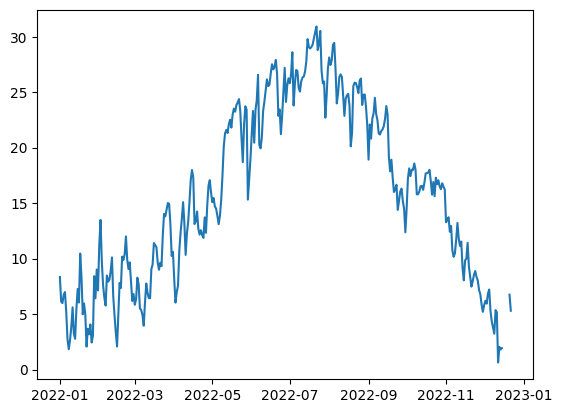

In [298]:
plt.plot(sensor_series['data'],sensor_series['valore'])